In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import numpy.linalg as LA
import h5py

from planning_utils import a_star, a_star_graph, valid_actions, point, closest_point, collinearity_check, prune_path, heuristic, create_grid, create_grid_and_edges, global_to_local, local_to_global
from config import Config

%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20

## Configuration values

In [15]:
# Obtaining 
config = Config()

outputPath = "./waypoints.hdf5"

# Static drone altitude (meters)
drone_altitude = 5.0

# Minimum distance stay away from obstacle (meters)
safe_distance = 5.0

# Select the method [grid_search, graph_search]
method = "graph_search"

# Include here the values of NED of final position
north = 600
east = 100
down = drone_altitude

ned_position = (north - config.north_home, east - config.east_home, down - config.down_home)
global_home = (config.long, config.lat, config.up)

global_position = local_to_global(ned_position, global_home)
#print(global_position)

start_ne = config.start_ne
goal_ne = (north, east)

## Compute the path from start to end

[INFO] Creating grid ...
[INFO] Creating graph...
[INFO] Finding the closest point...
[INFO] Using A* to calculate the path...
Found a path.
[INFO] Pruning the path...
[INFO] Converting path to waypoints...
[INFO] Plotting figure...


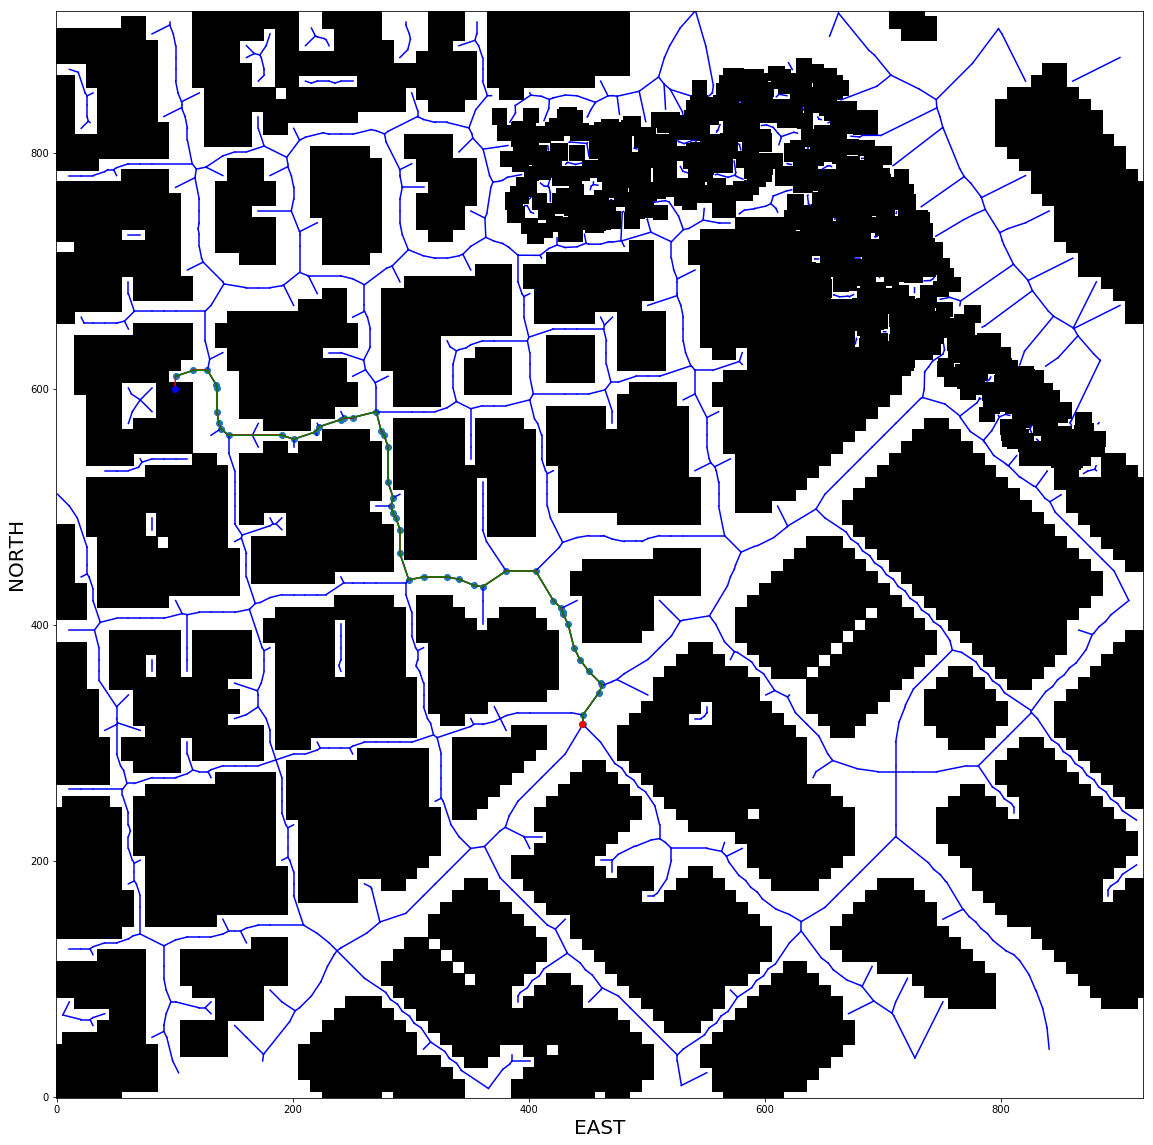

In [16]:
# Read all the values from obstacles in csv file;
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

waypoints = []

if method == "grid_search":
    
    print("[INFO] Creating grid...")
    grid, north_offset, east_offset = create_grid(data, drone_altitude, safe_distance)

    print("[INFO] Using A* to calculate the path...")
    path, cost = a_star(grid, heuristic, start_ne, goal_ne)

    print("[INFO] Pruning the path...")
    pruned_path = prune_path(path)
    
    print("[INFO] Converting waypoints to path...")
    waypoints = [[int(p[0]) + north_offset, int(p[1]) + east_offset, int(drone_altitude), 0] for p in pruned_path]
    
    print("[INFO] Plotting figure...")
    plt.imshow(grid, cmap='Greys', origin='lower')

    plt.plot(start_ne[1], start_ne[0], 'rx')
    plt.plot(goal_ne[1], goal_ne[0], 'gx')

    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

    plt.xlabel('EAST')
    plt.ylabel('NORTH')

    plt.show()

elif method == "graph_search":
    
    print("[INFO] Creating grid ...")
    grid, edges = create_grid_and_edges(data, drone_altitude, safe_distance)
    
    print("[INFO] Creating graph...")
    G = nx.Graph()
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        dist = LA.norm(np.array(p2) - np.array(p1))
        G.add_edge(p1, p2, weight=dist)
    
    print("[INFO] Finding the closest point...")
    start_ne_g = closest_point(G, start_ne)
    goal_ne_g = closest_point(G, goal_ne)
    
    print("[INFO] Using A* to calculate the path...")
    path, cost = a_star_graph(G, heuristic, start_ne_g, goal_ne_g)
    
    print("[INFO] Pruning the path...")
    pruned_path = prune_path(path)
    
    print("[INFO] Converting path to waypoints...")
    waypoints = [[int(p[0]) + config.north_offset, int(p[1]) + config.east_offset, int(drone_altitude), 0] for p in pruned_path]
    
    print("[INFO] Plotting figure...")
    plt.imshow(grid, origin='lower', cmap='Greys') 

    for e in edges:
        p1 = e[0]
        p2 = e[1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
    plt.plot([start_ne[1], start_ne_g[1]], [start_ne[0], start_ne_g[0]], 'r-')
    for i in range(len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
    plt.plot([goal_ne[1], goal_ne_g[1]], [goal_ne[0], goal_ne_g[0]], 'r-')
    
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

    plt.plot(start_ne[1], start_ne[0], 'ro')
    plt.plot(goal_ne[1], goal_ne[0], 'bo')

    plt.xlabel('EAST', fontsize=20)
    plt.ylabel('NORTH', fontsize=20)
    plt.show()
    


## Save waypoints values in hdf5 file

In [17]:
data_file = h5py.File('waypoints.hdf5', 'w')
data_file.create_dataset('data', data=waypoints)
data_file.close()
print("Waypoints.hdf5 saved successufully")

Waypoints.hdf5 saved successufully
